# HW3 

### part 1

In [1]:
# install package
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

使用 python 語言 並載入 numpy 跟 sklearn 所需要套件

In [2]:
#load the data
doc=[]

for i in range(1,1096):
    f = open('../PA1-data/'+str(i)+'.txt')
    txt=''
    for j in f.readlines():
        txt+=j.strip('\n').lower() 
        
    doc.append(txt)
    
    f.close()

讀入題目文字檔案並將他們全部都移除換行符號、轉為小寫，依序放入doc這個list裡面

確認doc的內容，以及是否將1095個題目文字檔案全部放入doc中。

In [3]:
len(doc)

1095

In [4]:
df=pd.DataFrame(doc,columns={'text'})

In [5]:
df["label"] = False
df["Id"] = range(1,1096)

In [6]:
df

,text,label,Id
0,the white house is also keeping a close watch ...,False,1
1,"turning to news overseas, a tense political sh...",False,2
2,pressing a strategy of legal challenges and po...,False,3
3,"in yugoslavia, the democratic opposition will ...",False,4
4,the yugoslavia opposition is urging its suppor...,False,5
...,...,...,...
1090,in western india wednesday rescue workers pull...,False,1091
1091,while the international relief effort and some...,False,1092
1092,as the death toll from last week's devastating...,False,1093
1093,a massive international relief effort continue...,False,1094


In [7]:
#讀入training.txt並做處理

train_txt=np.loadtxt('../training.txt')

In [8]:
for i in range(13):
    
    for j in range(1,16):
        
        row_num = train_txt[i][j]-1
        
        df.loc[ row_num, 'label'] = i+1

(array([968., 120.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  105. ,  5633.1, 11161.2, 16689.3, 22217.4, 27745.5, 33273.6,
        38801.7, 44329.8, 49857.9, 55386. ]),
 <a list of 10 Patch objects>)

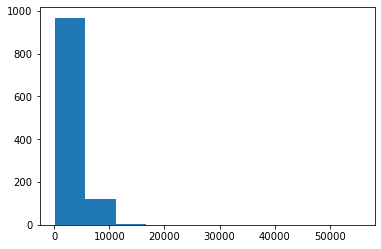

In [19]:
plt.hist(df['text'].apply(lambda x:len(x)))

In [20]:
df['text'] = df['text'].apply(lambda x:x.replace('\n\n',' '))
df['text'] = df['text'].apply(lambda x:x.replace('\n',' '))

In [21]:
# 分成test data and train data
test=df[df["label"]==False]

In [22]:
train=df[df["label"]!=False]

In [23]:
#shuffle
train = shuffle(train,random_state=123)

In [24]:
train

,text,label,Id
725,president clinton has pardoned a former leadin...,4,726
4,the yugoslavia opposition is urging its suppor...,2,5
400,a russian scientist has told the moscow city c...,8,401
994,a moderate earthquake rattled southern pakista...,6,995
816,turning to other news in el salvador. damage r...,3,817
...,...,...,...
28,"two months ago, the kursk, a russian nuclear s...",1,29
533,a government commission testified in an espion...,8,534
308,the military government in ivory coast has rej...,10,309
703,there was a rare display of power in washingto...,4,704


In [25]:
train_x = train["text"].values

In [26]:
label = train["label"].astype("int").values

In [27]:
train_y = label_binarize(label, classes=[1,2,3,4,5,6,7,8,9,10,11,12,13]) 
n_classes = train_y.shape[1]
n_classes

13

In [28]:
train_x.shape

(195,)

In [29]:
train_y.shape

(195, 13)

### part2 Bert 

In [37]:
from keras_bert import extract_embeddings
from keras_bert import load_vocabulary
from keras_bert import Tokenizer

model_path = 'uncased_L-12_H-768_A-12'
dict_path = 'uncased_L-12_H-768_A-12/vocab.txt'

使用keras_bert套件，Extract the [CLS] embedding of each training document!

In [38]:
bert_token_dict = load_vocabulary(dict_path)
bert_tokenizer = Tokenizer(bert_token_dict)

In [40]:
embeddings = extract_embeddings(model_path, list(train_x))

In [48]:
len(embeddings)

195

In [49]:
bert_embeddings_train = []

In [50]:
for i in range(len(embeddings)):
    bert_embeddings_train.append(embeddings[i][0])

In [51]:
bert_embeddings_train = np.array(bert_embeddings_train)

In [52]:
bert_embeddings_train

array([[ 1.1216588 ,  0.25997722,  0.37602586, ..., -0.58797586,
         0.3167487 , -0.01458152],
       [ 0.9702809 ,  0.19018511,  0.3449396 , ..., -0.4626849 ,
         0.5405567 , -0.03389881],
       [ 1.1057827 ,  0.69316095, -0.04091293, ..., -0.38074648,
         0.35427144,  0.08803821],
       ...,
       [ 0.40347892,  0.13062027,  0.08018038, ..., -0.26701546,
         0.12566899, -0.11353832],
       [ 0.5122454 ,  0.3182407 , -0.04990166, ..., -0.41022882,
        -0.04992519,  0.50156707],
       [ 1.1966597 ,  0.17456895,  0.34178662, ...,  0.17076313,
         0.5700154 , -0.15456855]], dtype=float32)

In [54]:
bert_embeddings_train.shape

(195, 768)

In [55]:
# split 10% of training set for evaluation
x_train=bert_embeddings_train[:175]
y_train=train_y[:175]
x_evaluation=bert_embeddings_train[175:]
y_evaluation=train_y[175:]

### SVM : Linear kernel 

In [56]:
model=OneVsRestClassifier(SVC(kernel='linear',C=1.0,probability=True,random_state=123))

In [57]:
model.fit(x_train,y_train)

OneVsRestClassifier(estimator=SVC(kernel='linear', probability=True,
                                  random_state=123))

In [59]:
predicted_results=[]
expected_results=[]
expected_results.extend(y_evaluation)
predicted_results.extend(model.predict(x_evaluation))

In [60]:
predicted_results

[array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])]

In [61]:
# Show precision, recall, and F1 scores
# micro avg  F1 scores : 1.00
print(metrics.classification_report(expected_results,predicted_results))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       0.00      0.00      0.00         0
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00        20
   macro avg       0.85      0.85      0.85        20
weighted avg       1.00      1.00      1.00        20
 samples avg       1.00      1.00      1.00        20



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
#plot precision recall curves
y_score = model.fit(x_train, y_train).decision_function(x_evaluation)

In [63]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_evaluation[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_evaluation[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_evaluation.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_evaluation, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=1.00')

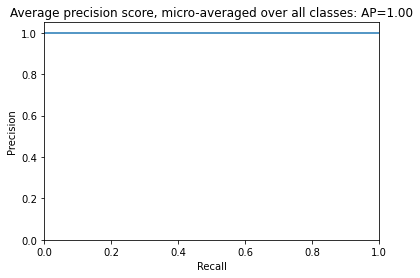

In [64]:
#plot precision recall curves
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

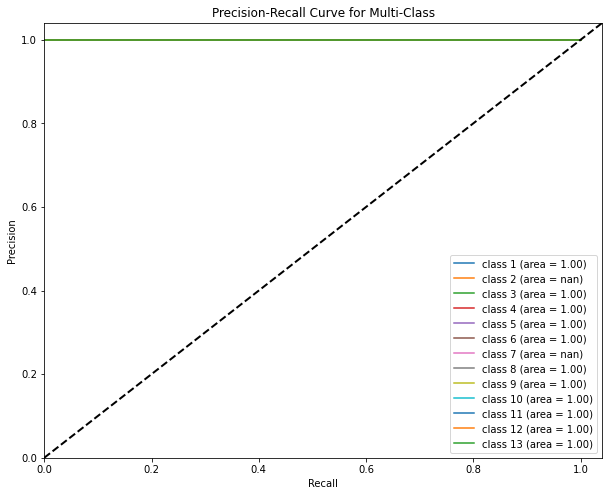

In [65]:
#plot precision recall curves
plt.figure(figsize=(10, 8))


for i in range(n_classes):
    plt.plot(recall[i], precision[i], label='class {0} (area = {1:0.2f})'.format
    (i+1, average_precision[i]))
    
plt.plot([0, 1.04], [0, 1.04], 'k--', lw=2) 
plt.xlim([0.0, 1.04])
plt.ylim([0.0, 1.04])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class') 
plt.legend(loc="best")
plt.show()

### predict and submit to Kaggle

In [69]:
df2=pd.concat([train,test])

In [70]:
df2

,text,label,Id
725,president clinton has pardoned a former leadin...,4,726
4,the yugoslavia opposition is urging its suppor...,2,5
400,a russian scientist has told the moscow city c...,8,401
994,a moderate earthquake rattled southern pakista...,6,995
816,turning to other news in el salvador. damage r...,3,817
...,...,...,...
1090,in western india wednesday rescue workers pull...,False,1091
1091,while the international relief effort and some...,False,1092
1092,as the death toll from last week's devastating...,False,1093
1093,a massive international relief effort continue...,False,1094


In [72]:
text=df2['text'].values

In [73]:
label=df2['label'].astype('int').values

In [76]:
len(text)

1095

In [77]:
embeddings = extract_embeddings(model_path, list(text))

In [78]:
len(embeddings)

1095

In [79]:
bert_embeddings = []
for i in range(len(embeddings)):
    bert_embeddings.append(embeddings[i][0])

In [80]:
bert_embeddings = np.array(bert_embeddings)

In [81]:
bert_embeddings.shape

(1095, 768)

In [82]:
train_x=bert_embeddings[:195]
train_y=label[:195]
test_x=bert_embeddings[195:]

In [83]:
model2=SVC(kernel='linear',C=1.0,probability=True,random_state=123)

In [84]:
model2.fit(train_x,train_y)

SVC(kernel='linear', probability=True, random_state=123)

In [85]:
predicted_y=[]
predicted_y.extend(model2.predict(test_x))

In [86]:
predicted_y

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 11,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 9,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 13,
 2,
 2,
 2,
 13,
 2,
 2,
 2,
 2,
 2,
 11,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 10,
 4,
 2,
 2,
 2,
 2,
 2,
 11,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 13,
 9,
 13,
 11,
 9,
 13,
 13,
 9,
 9,
 9,
 9,
 1,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 1,
 9,
 9,
 9,
 9,
 9,
 9,
 2,
 9,
 9,
 9,
 9,
 9,
 11,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 13,
 9,
 13,
 9,
 9,
 13,
 9,
 1,
 9,
 9,
 9,
 9,
 9,
 13,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 1,
 9,
 9,
 9,
 9,
 9,
 2,
 9,
 9,
 9,
 9,
 9,
 2,
 9,
 1,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 2,
 9,
 9,
 9,
 9,
 9,
 12,
 9,
 9,
 9,
 11,
 9,
 9,
 13,
 9,
 9,
 9,
 9,
 13,
 13,
 9,
 13,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 11,
 9,
 9,
 11,
 9,
 9,
 11,
 9,
 9,
 9,

In [87]:
test.loc[:,'Value']=predicted_y

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [88]:
test

,text,label,Id,Value
16,serbia remains tense today in the wake of a ma...,False,17,2
17,slobodan milosevic's government threatened to ...,False,18,2
19,"in yugoslavia, at least six cities lost power ...",False,20,2
20,while there may be some home for secretary alb...,False,21,2
21,"in yugoslavia today, the government of sloboda...",False,22,2
...,...,...,...,...
1090,in western india wednesday rescue workers pull...,False,1091,6
1091,while the international relief effort and some...,False,1092,6
1092,as the death toll from last week's devastating...,False,1093,6
1093,a massive international relief effort continue...,False,1094,6


In [89]:
ans=test[["Id",'Value']]

In [90]:
ans

,Id,Value
16,17,2
17,18,2
19,20,2
20,21,2
21,22,2
...,...,...
1090,1091,6
1091,1092,6
1092,1093,6
1093,1094,6


In [91]:
# 將預測結果存成csv檔，並上傳到 Kaggle
ans.to_csv("hw3_submission_kaggle.csv",index=None)